In [1]:
import csv
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(0)

In [3]:
pd.set_option('display.max_rows', None)

## Setting up the simulation

In [4]:
def build_houses_dict(houses_x, houses_y, min_household, max_household, app_penetration):
    
    houses_dict = {}
    total_people = 0

    for i, coordinates in enumerate(zip(houses_x, houses_y)):

        houses_dict[i] = {}
        
        num_people = np.random.randint(low=min_household, high=max_household)
        total_people += num_people

        houses_dict[i]['coordinates'] = coordinates 
        houses_dict[i]['num_people'] = num_people
        houses_dict[i]['infected'] = np.zeros(num_people, dtype=bool)
        houses_dict[i]['exposed'] = np.zeros(num_people, dtype=bool)
        houses_dict[i]['has_app'] = np.random.choice([False, True], 
                                                             p=[1-app_penetration, app_penetration], 
                                                             size=num_people)
        houses_dict[i]['infection_present'] = False

    return houses_dict, total_people

In [5]:
def build_landmarks_dict(landmarks_x, landmarks_y):
    
    landmarks_dict = {}

    for i, coordinates in enumerate(zip(landmarks_x, landmarks_y)):

        landmarks_dict[i] = {}
        landmarks_dict[i]['coordinates'] = coordinates

    return landmarks_dict

In [6]:
def build_individuals_in_dict(houses_dict, total_people, leave_prob_exposed, leave_prob_no_app):
    
    individuals_in_dict = {}
    counter = 0

    for i in houses_dict:

        num_people = houses_dict[i]['num_people']

        for j in range(num_people):

            individuals_in_dict[counter] = {}

            individuals_in_dict[counter]['house_number'] = i
            individuals_in_dict[counter]['index_number'] = j
            individuals_in_dict[counter]['infected_in'] = houses_dict[i]['infected'][j]
            individuals_in_dict[counter]['exposed_in'] = houses_dict[i]['exposed'][j]
            individuals_in_dict[counter]['has_app'] = houses_dict[i]['has_app'][j]
            
            if individuals_in_dict[counter]['exposed_in'] and individuals_in_dict[counter]['has_app']:
                leave_house = np.random.choice([False, True], p=[1-leave_prob_exposed, leave_prob_exposed])
            else:
                leave_house = np.random.choice([False, True], p=[1-leave_prob_no_app, leave_prob_no_app])
            
            individuals_in_dict[counter]['leave_house'] = leave_house
            
            if leave_house:
                individuals_in_dict[counter]['landmark_visit'] = np.random.randint(low=0, high=landmarks_n)

            counter += 1

    assert total_people == counter

    return individuals_in_dict

In [7]:
def build_landmarks_visitors_dict(individuals_in_dict):
    
    landmarks_visitors_dict = {}

    for i in range(landmarks_n):

        landmarks_visitors_dict[i] = {}
        landmarks_visitors_dict[i]['visitors'] = []
        landmarks_visitors_dict[i]['infection_present'] = False

    for i in individuals_in_dict:

        if individuals_in_dict[i]['leave_house']:
            landmark_visit = individuals_in_dict[i]['landmark_visit']
            landmarks_visitors_dict[landmark_visit]['visitors'].append(i)

            if individuals_in_dict[i]['infected_in']:
                landmarks_visitors_dict[landmark_visit]['infection_present'] = True

    return landmarks_visitors_dict

In [8]:
def build_individuals_out_dict(landmarks_visitors_dict, individuals_in_dict, 
                               houses_dict, public_spread, random_spread):

    individuals_out_dict = copy.deepcopy(individuals_in_dict)

    for i in individuals_out_dict:
        
        if individuals_out_dict[i]['leave_house']:

            landmark_visit = individuals_out_dict[i]['landmark_visit']

            if individuals_out_dict[i]['exposed_in']:
                individuals_out_dict[i]['exposed_out'] = True
            else:
                individuals_out_dict[i]['exposed_out'] = landmarks_visitors_dict[landmark_visit]['infection_present']

            if individuals_out_dict[i]['infected_in']:
                individuals_out_dict[i]['infected_out'] = True
            elif individuals_out_dict[i]['exposed_out']:
                individuals_out_dict[i]['infected_out'] = np.random.choice([False, True], 
                                                                           p=[1-public_spread, public_spread])
            else:
                individuals_out_dict[i]['infected_out'] = np.random.choice([False, True], 
                                                                           p=[1-random_spread, random_spread])

            house_number = individuals_out_dict[i]['house_number']
            index_number = individuals_out_dict[i]['index_number']

            if individuals_out_dict[i]['infected_out']:
                individuals_out_dict[i]['exposed_out'] = True
                houses_dict[house_number]['infected'][index_number] = True
                houses_dict[house_number]['infection_present'] = True

            if individuals_out_dict[i]['exposed_out']:
                houses_dict[house_number]['exposed'][index_number] = True

    return individuals_out_dict

In [9]:
def update_houses_dict(houses_dict, house_spread):

    for i in houses_dict:
        for j in range(houses_dict[i]['num_people']):
            if houses_dict[i]['infection_present']:
                houses_dict[i]['exposed'][j] = True
                if houses_dict[i]['infected'][j] == False:
                    houses_dict[i]['infected'][j] = np.random.choice([False, True], p=[1-house_spread, house_spread])

    return houses_dict

In [10]:
def run_simulation(num_days, houses_n, houses_x, houses_y, landmarks_n, landmarks_x, landmarks_y,
                   min_household, max_household, app_penetration, leave_prob_exposed, leave_prob_no_app,
                   public_spread, random_spread, house_spread, display_dicts):
    
    houses_dict, total_people = build_houses_dict(houses_x, houses_y, min_household, max_household, app_penetration)
    landmarks_dict = build_landmarks_dict(landmarks_x, landmarks_y)
    people_infected = []
    
    for i in range(num_days):
        
        if display_dicts:
            print(f"\nhouses_day{i}")
            display(pd.DataFrame(houses_dict).transpose())
        
        individuals_in_dict = build_individuals_in_dict(houses_dict, total_people, 
                                                        leave_prob_exposed, leave_prob_no_app)
        landmarks_visitors_dict = build_landmarks_visitors_dict(individuals_in_dict)
        individuals_out_dict = build_individuals_out_dict(landmarks_visitors_dict, individuals_in_dict, 
                                                          houses_dict, public_spread, random_spread)
        houses_dict = update_houses_dict(houses_dict, house_spread)
        
        people_infected_temp = 0
        for j in houses_dict:
            people_infected_temp += sum(houses_dict[j]['infected'])
            
        people_infected.append(people_infected_temp)
        
        if display_dicts:
            print(f"\nindividuals_in_day{i}")
            display(pd.DataFrame(individuals_in_dict).transpose())
            print(f"\nlandmarks_visitors_day{i}")
            display(pd.DataFrame(landmarks_visitors_dict).transpose())
            print(f"\nindividuals_out_day{i}")
            display(pd.DataFrame(individuals_out_dict).transpose())
        
    return houses_dict, total_people, people_infected

## Simulation runs

In [11]:
houses_n = 1000
houses1_x = np.random.uniform(0, 800, houses_n//4)
houses1_y = np.random.uniform(0, 200, houses_n//4)
houses2_x = np.random.uniform(800, 1000, houses_n//4)
houses2_y = np.random.uniform(0, 800, houses_n//4)
houses3_x = np.random.uniform(200, 1000, houses_n//4)
houses3_y = np.random.uniform(800, 1000, houses_n//4)
houses4_x = np.random.uniform(0, 200, houses_n//4)
houses4_y = np.random.uniform(200, 1000, houses_n//4)
houses_x = np.concatenate([houses1_x, houses2_x, houses3_x, houses4_x])
houses_y = np.concatenate([houses1_y, houses2_y, houses3_y, houses4_y])

landmarks_n = 10
landmarks_x = np.random.uniform(300, 700, landmarks_n)
landmarks_y = np.random.uniform(300, 700, landmarks_n)

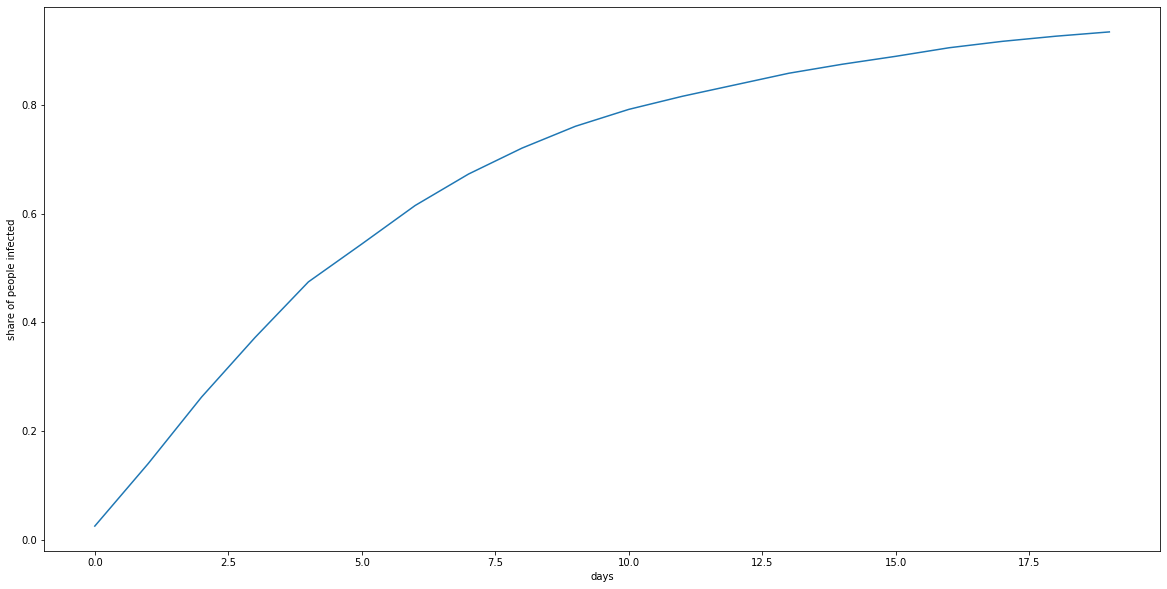

In [12]:
min_household = 1
max_household = 5
app_penetration = 0.2
leave_prob_exposed = 0.6
leave_prob_no_app = 0.6
public_spread = 0.10
random_spread = 0.02
house_spread = 0.50
num_days = 20
display_dicts = False

houses_dict, total_people, people_infected = run_simulation(num_days, houses_n, houses_x, houses_y, 
                                                            landmarks_n, landmarks_x, landmarks_y, 
                                                            min_household, max_household, app_penetration,
                                                            leave_prob_exposed, leave_prob_no_app,
                                                            public_spread, random_spread, house_spread, 
                                                            display_dicts)

days = list(range(num_days))
infected_share = [n/total_people for n in people_infected]

plt.figure(figsize=(20,10))
plt.plot(days, infected_share)
plt.xlabel('days')
plt.ylabel('share of people infected')
plt.show()

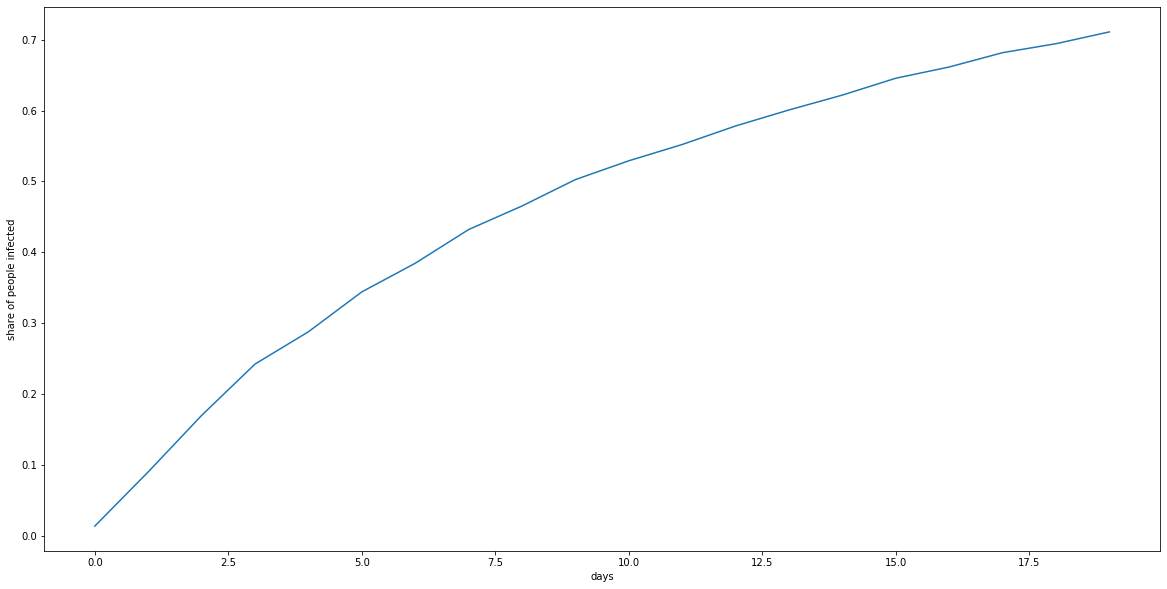

In [13]:
min_household = 1
max_household = 5
app_penetration = 0.2
leave_prob_exposed = 0.20
leave_prob_no_app = 0.5
public_spread = 0.10
random_spread = 0.02
house_spread = 0.50
num_days = 20
display_dicts = False

houses_dict, total_people, people_infected = run_simulation(num_days, houses_n, houses_x, houses_y, 
                                                            landmarks_n, landmarks_x, landmarks_y, 
                                                            min_household, max_household, app_penetration,
                                                            leave_prob_exposed, leave_prob_no_app,
                                                            public_spread, random_spread, house_spread, 
                                                            display_dicts)

days = list(range(num_days))
infected_share = [n/total_people for n in people_infected]

plt.figure(figsize=(20,10))
plt.plot(days, infected_share)
plt.xlabel('days')
plt.ylabel('share of people infected')
plt.show()

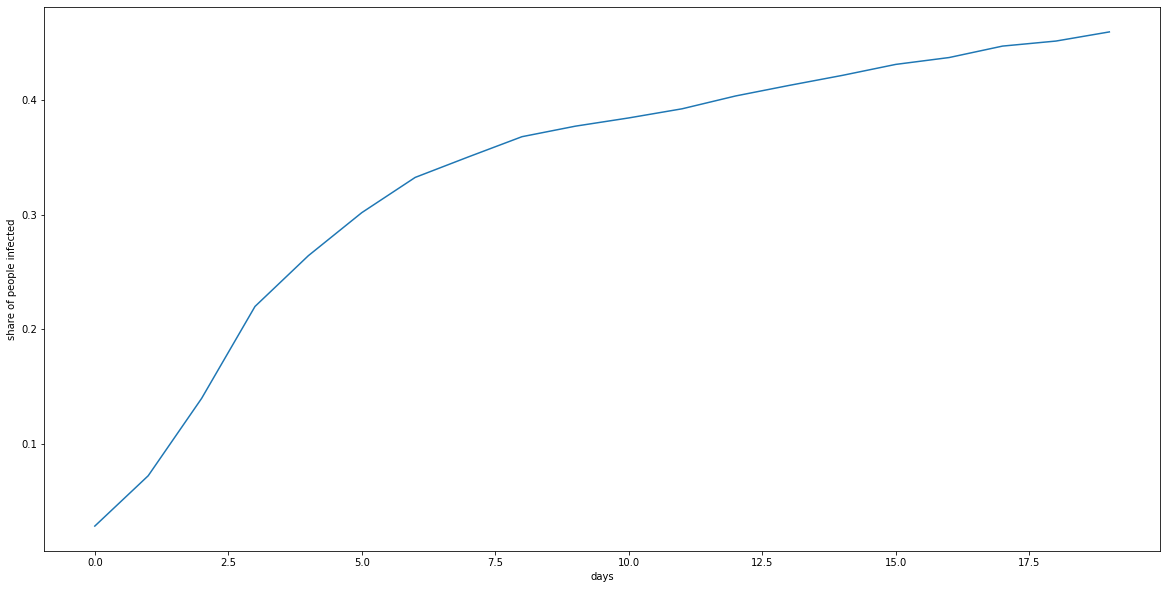

In [14]:
min_household = 1
max_household = 5
app_penetration = 0.2
leave_prob_exposed = 0.05
leave_prob_no_app = 0.5
public_spread = 0.10
random_spread = 0.02
house_spread = 0.50
num_days = 20
display_dicts = False

houses_dict, total_people, people_infected = run_simulation(num_days, houses_n, houses_x, houses_y, 
                                                            landmarks_n, landmarks_x, landmarks_y, 
                                                            min_household, max_household, app_penetration,
                                                            leave_prob_exposed, leave_prob_no_app,
                                                            public_spread, random_spread, house_spread, 
                                                            display_dicts)


days = list(range(num_days))
infected_share = [n/total_people for n in people_infected]

plt.figure(figsize=(20,10))
plt.plot(days, infected_share)
plt.xlabel('days')
plt.ylabel('share of people infected')
plt.show()

## Grid search

In [12]:
houses_n = 100
houses1_x = np.random.uniform(0, 800, houses_n//4)
houses1_y = np.random.uniform(0, 200, houses_n//4)
houses2_x = np.random.uniform(800, 1000, houses_n//4)
houses2_y = np.random.uniform(0, 800, houses_n//4)
houses3_x = np.random.uniform(200, 1000, houses_n//4)
houses3_y = np.random.uniform(800, 1000, houses_n//4)
houses4_x = np.random.uniform(0, 200, houses_n//4)
houses4_y = np.random.uniform(200, 1000, houses_n//4)
houses_x = np.concatenate([houses1_x, houses2_x, houses3_x, houses4_x])
houses_y = np.concatenate([houses1_y, houses2_y, houses3_y, houses4_y])

landmarks_n = 10
landmarks_x = np.random.uniform(300, 700, landmarks_n)
landmarks_y = np.random.uniform(300, 700, landmarks_n)

In [13]:
%%time

steps = 11
num_days = 6

leave_prob_exposed_grid = np.linspace(start=0, stop=1, num=steps)
leave_prob_not_exposed_grid = np.linspace(start=0, stop=1, num=steps)

total_people_array = np.zeros((steps, steps))
people_infected_array = np.zeros((steps, steps, num_days))

for i, p_exp in enumerate(leave_prob_exposed_grid):
    for j, p_not_exp in enumerate(leave_prob_not_exposed_grid):

        houses_dict, total_people, people_infected = run_simulation(num_days=num_days, 
                                                                    houses_n=houses_n, 
                                                                    houses_x=houses_x, 
                                                                    houses_y=houses_y, 
                                                                    landmarks_n=landmarks_n, 
                                                                    landmarks_x=landmarks_x, 
                                                                    landmarks_y=landmarks_y, 
                                                                    min_household=1, 
                                                                    max_household=5, 
                                                                    leave_prob_exposed=p_exp, 
                                                                    leave_prob_not_exposed=p_not_exp,
                                                                    public_spread=0.10, 
                                                                    random_spread=0.02, 
                                                                    house_spread=0.50, 
                                                                    display_dicts=False)
        
        total_people_array[i,j] = total_people
        people_infected_array[i,j,:] = people_infected

CPU times: user 8.56 s, sys: 207 ms, total: 8.76 s
Wall time: 8.7 s


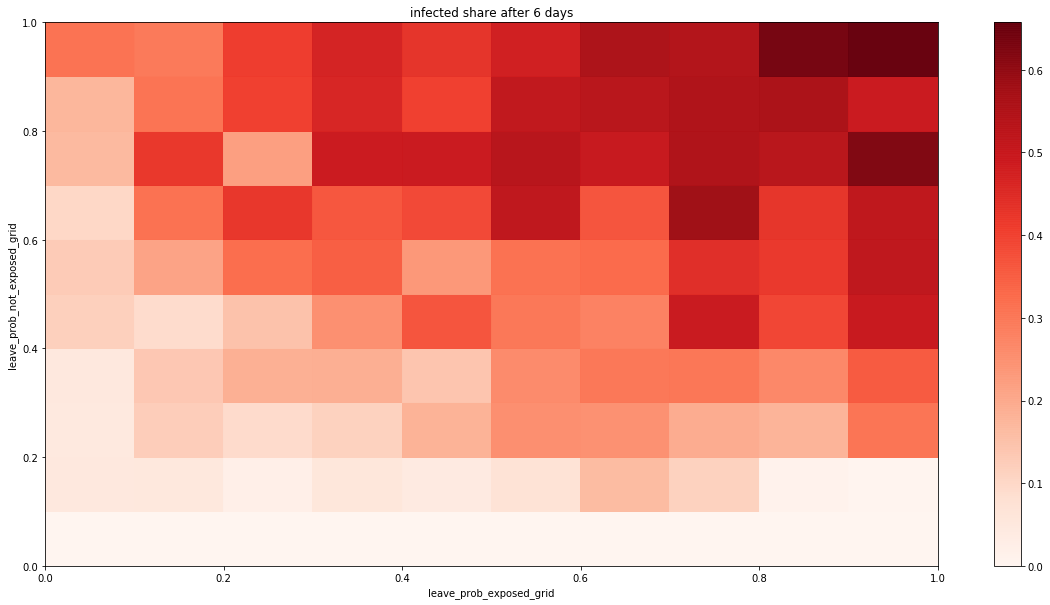

In [20]:
infected_share = np.divide(people_infected_array[:,:,-1], total_people_array)

plt.figure(figsize=(20,10))
plt.pcolormesh(leave_prob_exposed_grid, leave_prob_not_exposed_grid, np.transpose(infected_share),
               alpha=0.99, cmap='Reds')

plt.title(f'infected share after {num_days} days')
plt.xlabel('leave_prob_exposed_grid')
plt.ylabel('leave_prob_not_exposed_grid')
plt.colorbar()
plt.show()

## Grid search

In [57]:
# Urban
# New York City, New York
# 116 Historic Landmarks - https://en.wikipedia.org/wiki/List_of_National_Historic_Landmarks_in_New_York_City
# 3,154,103 Households - https://www.census.gov/quickfacts/fact/table/newyorkcitynewyork/HSD410218
print(f"New York {int((3154103/116)/100)}x")

# Sprawl
# Austin, Texas
# 2 Historic Landmarks - https://en.wikipedia.org/wiki/List_of_National_Historic_Landmarks_in_Texas
# 370,043 Households - https://www.census.gov/quickfacts/fact/table/austincitytexas/PST045219
print(f"Austin {int((370043/2)/100)}x")

# Average
# Omaha, Nebraska
# 3 Historic Landmarks - https://en.wikipedia.org/wiki/List_of_National_Historic_Landmarks_in_Nebraska
# 183,160 Households - https://www.census.gov/quickfacts/fact/table/omahacitynebraska,US/PST045219
print(f"Omaha {int((183160/3)/100)}x")


New York 271x
Austin 1850x
Omaha 610x


In [85]:
houses_n = 500
houses1_x = np.random.uniform(0, 800, houses_n//4)
houses1_y = np.random.uniform(0, 200, houses_n//4)
houses2_x = np.random.uniform(800, 1000, houses_n//4)
houses2_y = np.random.uniform(0, 800, houses_n//4)
houses3_x = np.random.uniform(200, 1000, houses_n//4)
houses3_y = np.random.uniform(800, 1000, houses_n//4)
houses4_x = np.random.uniform(0, 200, houses_n//4)
houses4_y = np.random.uniform(200, 1000, houses_n//4)
houses_x = np.concatenate([houses1_x, houses2_x, houses3_x, houses4_x])
houses_y = np.concatenate([houses1_y, houses2_y, houses3_y, houses4_y])

landmarks_n = 50
landmarks_x = np.random.uniform(300, 700, landmarks_n)
landmarks_y = np.random.uniform(300, 700, landmarks_n)

In [88]:
%%time

steps = 11
num_days = 30
carriers = 0.02        # MedicalNewsToday states 1-3% of people aymptomatic carriers
surface = 0.005        # Small chance of extended time surface transmission
proximate_spread = 0.5 # Change you'll get it from housemates in close proximity
leave_home = 0.35       # Probability you'll leave your home on any day (if you don't have the app)

# Quarantine:
# 35% because 64.6% average drop in mobility in France (mandatory travel restrictions) according to Google Mobility
# https://www.gstatic.com/covid19/mobility/2020-04-17_FR_Mobility_Report_en.pdf
# 95% chance you leave your home on normal day
# 75% chance for city/density studies, since more people will stay out of fear

app_penetration_grid = np.linspace(start=0, stop=1, num=steps)
leave_prob_exposed_grid = np.linspace(start=0, stop=1, num=steps)

total_people_array = np.zeros((steps, steps))
people_infected_array = np.zeros((steps, steps, num_days))

for i, p_app in enumerate(app_penetration_grid):
    for j, p_exp in enumerate(leave_prob_exposed_grid):

        houses_dict, total_people, people_infected = run_simulation(num_days=num_days, 
                                                                    houses_n=houses_n, 
                                                                    houses_x=houses_x, 
                                                                    houses_y=houses_y, 
                                                                    landmarks_n=landmarks_n, 
                                                                    landmarks_x=landmarks_x, 
                                                                    landmarks_y=landmarks_y, 
                                                                    min_household=1, 
                                                                    max_household=5,
                                                                    app_penetration=p_app,
                                                                    leave_prob_exposed=p_exp, 
                                                                    leave_prob_no_app=leave_home,
                                                                    public_spread=carriers, 
                                                                    random_spread=surface, 
                                                                    house_spread=proximate_spread, 
                                                                    display_dicts=False)
        
        total_people_array[i,j] = total_people
        people_infected_array[i,j,:] = people_infected

CPU times: user 3min 36s, sys: 2.02 s, total: 3min 38s
Wall time: 3min 40s


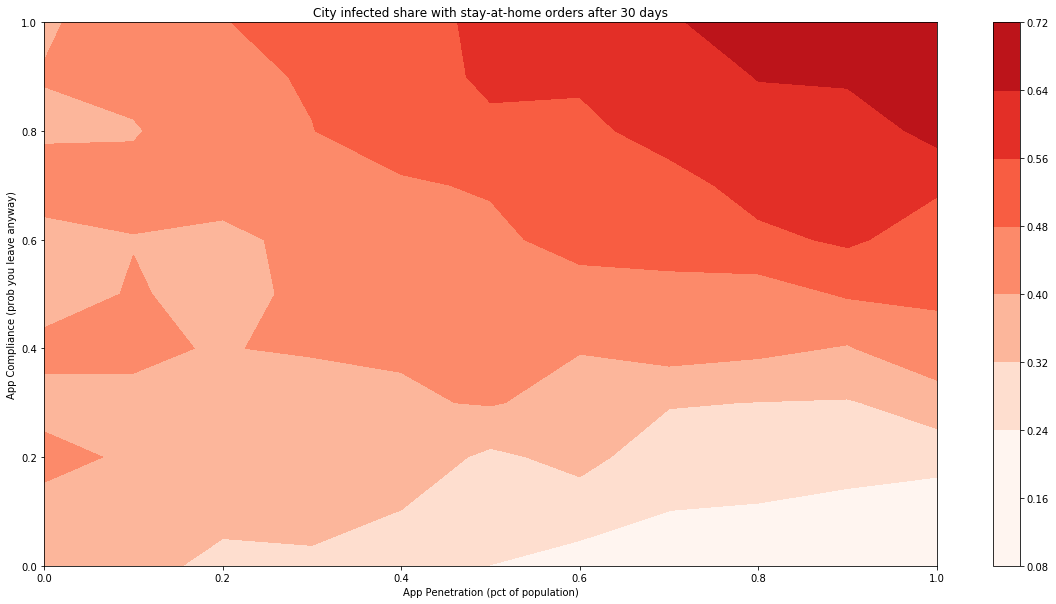

In [90]:
infected_share = np.divide(people_infected_array[:,:,-1], total_people_array)

plt.figure(figsize=(20,10))
plt.contourf(app_penetration_grid, leave_prob_exposed_grid, np.transpose(infected_share),
             vmin=0.2, vmax=0.8, cmap="Reds")

plt.title(f'City infected share with stay-at-home orders after {num_days} days')
plt.xlabel('App Penetration (pct of population)')
plt.ylabel('App Compliance (prob you leave anyway)')
plt.colorbar()
plt.show()

## For debugging

In [21]:
houses_n = 20
houses1_x = np.random.uniform(0, 800, houses_n//4)
houses1_y = np.random.uniform(0, 200, houses_n//4)
houses2_x = np.random.uniform(800, 1000, houses_n//4)
houses2_y = np.random.uniform(0, 800, houses_n//4)
houses3_x = np.random.uniform(200, 1000, houses_n//4)
houses3_y = np.random.uniform(800, 1000, houses_n//4)
houses4_x = np.random.uniform(0, 200, houses_n//4)
houses4_y = np.random.uniform(200, 1000, houses_n//4)
houses_x = np.concatenate([houses1_x, houses2_x, houses3_x, houses4_x])
houses_y = np.concatenate([houses1_y, houses2_y, houses3_y, houses4_y])

landmarks_n = 5
landmarks_x = np.random.uniform(300, 700, landmarks_n)
landmarks_y = np.random.uniform(300, 700, landmarks_n)

min_household = 1
max_household = 5
leave_prob_exposed = 0.05
leave_prob_not_exposed = 0.5
public_spread = 0.10
random_spread = 0.02
house_spread = 0.50
num_days = 3
display_dicts = True

houses_dict, total_people, people_infected = run_simulation(num_days, houses_n, houses_x, houses_y, 
                                                            landmarks_n, landmarks_x, landmarks_y, 
                                                            min_household, max_household, 
                                                            leave_prob_exposed, leave_prob_not_exposed,
                                                            public_spread, random_spread, house_spread, 
                                                            display_dicts)


houses_day0


,coordinates,num_people,infected,exposed,infection_present
0,"(245.72521322764018, 131.71057530994966)",3,"[False, False, False]","[False, False, False]",False
1,"(222.9034762710108, 129.79969633153283)",3,"[False, False, False]","[False, False, False]",False
2,"(298.56870972192684, 72.48473034637617)",3,"[False, False, False]","[False, False, False]",False
3,"(253.13203071373565, 76.33038840263218)",4,"[False, False, False, False]","[False, False, False, False]",False
4,"(90.18895311062147, 77.09515994738159)",4,"[False, False, False, False]","[False, False, False, False]",False
5,"(805.7863003174388, 313.93368314529965)",3,"[False, False, False]","[False, False, False]",False
6,"(818.6999886661075, 293.8207134856177)",4,"[False, False, False, False]","[False, False, False, False]",False
7,"(973.2297513656785, 408.2842972162992)",4,"[False, False, False, False]","[False, False, False, False]",False
8,"(902.2230256165705, 158.0658336606553)",3,"[False, False, False]","[False, False, False]",False
9,"(829.3275069857222, 61.11825678463836)",1,[False],[False],False



individuals_in_day0


,house_number,index_number,infected_in,exposed_in,leave_house,landmark_visit
0,0,0,False,False,False,NaN
1,0,1,False,False,True,2
2,0,2,False,False,True,3
3,1,0,False,False,True,0
4,1,1,False,False,True,3
5,1,2,False,False,False,NaN
6,2,0,False,False,True,0
7,2,1,False,False,True,3
8,2,2,False,False,True,3
9,3,0,False,False,True,2



landmarks_visitors_day0


,visitors,infection_present
0,"[3, 6, 13, 33, 43]",False
1,"[12, 21, 29, 30, 45, 52]",False
2,"[1, 9, 11, 14, 20, 55]",False
3,"[2, 4, 7, 8, 16, 17, 27, 32, 42]",False
4,[26],False



individuals_out_day0


,house_number,index_number,infected_in,exposed_in,leave_house,landmark_visit,exposed_out,infected_out
0,0,0,False,False,False,NaN,NaN,NaN
1,0,1,False,False,True,2,True,True
2,0,2,False,False,True,3,False,False
3,1,0,False,False,True,0,False,False
4,1,1,False,False,True,3,False,False
5,1,2,False,False,False,NaN,NaN,NaN
6,2,0,False,False,True,0,False,False
7,2,1,False,False,True,3,False,False
8,2,2,False,False,True,3,False,False
9,3,0,False,False,True,2,False,False



houses_day1


,coordinates,num_people,infected,exposed,infection_present
0,"(245.72521322764018, 131.71057530994966)",3,"[True, True, False]","[True, True, True]",True
1,"(222.9034762710108, 129.79969633153283)",3,"[False, False, False]","[False, False, False]",False
2,"(298.56870972192684, 72.48473034637617)",3,"[False, False, False]","[False, False, False]",False
3,"(253.13203071373565, 76.33038840263218)",4,"[False, False, False, False]","[False, False, False, False]",False
4,"(90.18895311062147, 77.09515994738159)",4,"[False, False, True, True]","[True, True, True, True]",True
5,"(805.7863003174388, 313.93368314529965)",3,"[False, False, False]","[False, False, False]",False
6,"(818.6999886661075, 293.8207134856177)",4,"[False, False, False, False]","[False, False, False, False]",False
7,"(973.2297513656785, 408.2842972162992)",4,"[False, False, False, False]","[False, False, False, False]",False
8,"(902.2230256165705, 158.0658336606553)",3,"[False, False, False]","[False, False, False]",False
9,"(829.3275069857222, 61.11825678463836)",1,[False],[False],False



individuals_in_day1


,house_number,index_number,infected_in,exposed_in,leave_house,landmark_visit
0,0,0,True,True,True,1
1,0,1,True,True,False,NaN
2,0,2,False,True,False,NaN
3,1,0,False,False,True,2
4,1,1,False,False,True,1
5,1,2,False,False,False,NaN
6,2,0,False,False,False,NaN
7,2,1,False,False,False,NaN
8,2,2,False,False,False,NaN
9,3,0,False,False,False,NaN



landmarks_visitors_day1


,visitors,infection_present
0,"[17, 41, 47, 50, 51]",False
1,"[0, 4, 19, 24, 26, 40]",True
2,"[3, 30, 36, 43, 52]",False
3,"[18, 28, 32, 53, 55]",False
4,"[22, 29, 31, 33, 39]",False



individuals_out_day1


,house_number,index_number,infected_in,exposed_in,leave_house,landmark_visit,exposed_out,infected_out
0,0,0,True,True,True,1,True,True
1,0,1,True,True,False,NaN,NaN,NaN
2,0,2,False,True,False,NaN,NaN,NaN
3,1,0,False,False,True,2,False,False
4,1,1,False,False,True,1,True,False
5,1,2,False,False,False,NaN,NaN,NaN
6,2,0,False,False,False,NaN,NaN,NaN
7,2,1,False,False,False,NaN,NaN,NaN
8,2,2,False,False,False,NaN,NaN,NaN
9,3,0,False,False,False,NaN,NaN,NaN



houses_day2


,coordinates,num_people,infected,exposed,infection_present
0,"(245.72521322764018, 131.71057530994966)",3,"[True, True, True]","[True, True, True]",True
1,"(222.9034762710108, 129.79969633153283)",3,"[False, False, False]","[False, True, False]",False
2,"(298.56870972192684, 72.48473034637617)",3,"[False, False, False]","[False, False, False]",False
3,"(253.13203071373565, 76.33038840263218)",4,"[False, False, False, False]","[False, False, False, False]",False
4,"(90.18895311062147, 77.09515994738159)",4,"[True, False, True, True]","[True, True, True, True]",True
5,"(805.7863003174388, 313.93368314529965)",3,"[True, False, True]","[True, True, True]",True
6,"(818.6999886661075, 293.8207134856177)",4,"[False, False, False, False]","[False, False, False, False]",False
7,"(973.2297513656785, 408.2842972162992)",4,"[False, False, False, False]","[True, False, True, False]",False
8,"(902.2230256165705, 158.0658336606553)",3,"[False, False, False]","[False, False, False]",False
9,"(829.3275069857222, 61.11825678463836)",1,[False],[False],False



individuals_in_day2


,house_number,index_number,infected_in,exposed_in,leave_house,landmark_visit
0,0,0,True,True,False,NaN
1,0,1,True,True,False,NaN
2,0,2,True,True,False,NaN
3,1,0,False,False,False,NaN
4,1,1,False,True,False,NaN
5,1,2,False,False,False,NaN
6,2,0,False,False,False,NaN
7,2,1,False,False,False,NaN
8,2,2,False,False,False,NaN
9,3,0,False,False,False,NaN



landmarks_visitors_day2


,visitors,infection_present
0,"[21, 32, 50, 51, 54]",False
1,"[39, 42, 47, 56]",False
2,"[25, 30, 33, 44, 53]",False
3,"[22, 27, 29, 45]",False
4,"[10, 20, 23, 28, 35, 37, 46, 49]",False



individuals_out_day2


,house_number,index_number,infected_in,exposed_in,leave_house,landmark_visit,exposed_out,infected_out
0,0,0,True,True,False,NaN,NaN,NaN
1,0,1,True,True,False,NaN,NaN,NaN
2,0,2,True,True,False,NaN,NaN,NaN
3,1,0,False,False,False,NaN,NaN,NaN
4,1,1,False,True,False,NaN,NaN,NaN
5,1,2,False,False,False,NaN,NaN,NaN
6,2,0,False,False,False,NaN,NaN,NaN
7,2,1,False,False,False,NaN,NaN,NaN
8,2,2,False,False,False,NaN,NaN,NaN
9,3,0,False,False,False,NaN,NaN,NaN


## Appendix

In [ ]:
# leave_prob_exposed vs. leave_prob_not_exposed mesh plot for different values of public_spread
# leave_prob_exposed vs. leave_prob_not_exposed (false positives) mesh plot for different values of public_spread
# low density, medium density, high density

In [ ]:
# Notes:
#     input: accuracy of data
# 
# output 1: spread and peak of spread
# output 2: false positive / false negative
# output 3: tracking spread of infection across geography

In [ ]:
#         f = open(f"data/individuals_in_dict_day{i}.txt","w"); f.write(str(individuals_in_dict)); f.close()
#         f = open(f"data/landmarks_visitors_dict_day{i}.txt","w"); f.write(str(landmarks_visitors_dict)); f.close()
#         f = open(f"data/individuals_out_dict_day{i}.txt","w"); f.write(str(individuals_out_dict)); f.close()
#         f = open(f"data/houses_dict_day{i}.txt","w"); f.write(str(houses_dict)); f.close()

# f = open(f"data/houses_dict_day{i}.csv","w"); w = csv.writer(f); w.writerows(houses_dict.items()); f.close()
# f = open(f"data/individuals_in_dict_day{i}.csv","w"); w = csv.writer(f); w.writerows(individuals_in_dict.items()); f.close()
# f = open(f"data/landmarks_visitors_dict_day{i}.csv","w"); w = csv.writer(f); w.writerows(landmarks_visitors_dict.items()); f.close()
# f = open(f"data/individuals_out_dict_day{i}.csv","w"); w = csv.writer(f); w.writerows(individuals_out_dict.items()); f.close()       

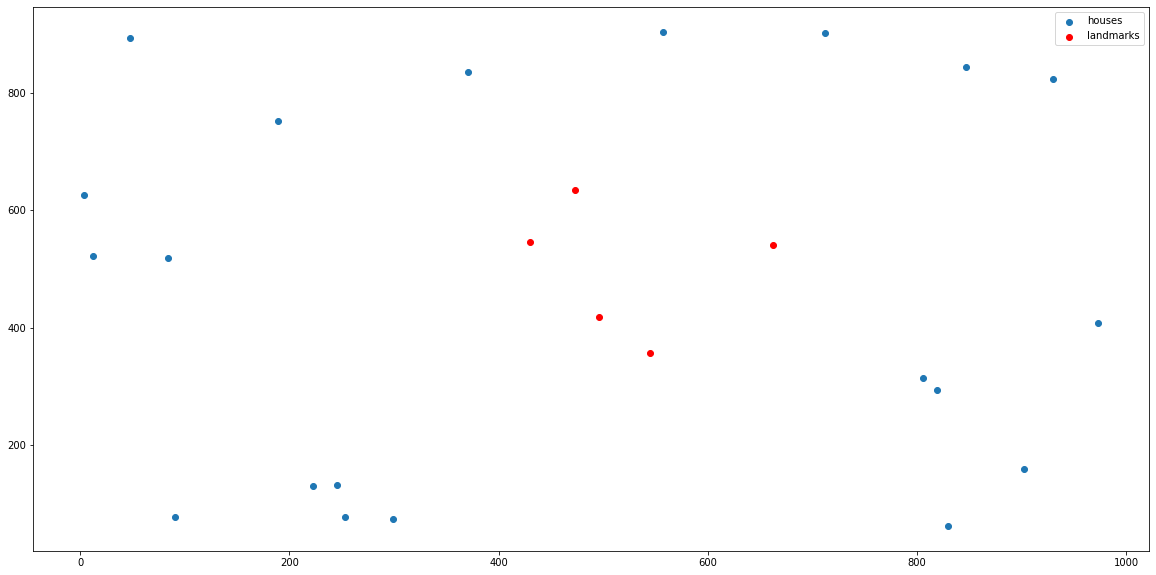

In [22]:
plt.figure(figsize=(20,10))
plt.scatter(houses_x, houses_y, label="houses")
plt.scatter(landmarks_x, landmarks_y, color="red", label="landmarks")
plt.legend()
plt.show()

In [23]:
days = list(range(num_days))

plt.figure(figsize=(20,10))

for i, p1 in enumerate(leave_prob_exposed):
    for j, p2 in enumerate(leave_prob_not_exposed):
        infected_share = [n/total_people for n in people_infected_array[i,j,:]]
        plt.plot(days, infected_share)

plt.xlabel('days')
plt.ylabel('share of people infected')
plt.show()

TypeError: 'float' object is not iterable

<Figure size 1440x720 with 0 Axes>